# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

# данные
train_data = pd.read_csv('/datasets/gold_recovery_train.csv')
test_data = pd.read_csv('/datasets/gold_recovery_test.csv')
full_data = pd.read_csv('/datasets/gold_recovery_full.csv')


print(train_data.info())
print(test_data.info())
print(full_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

Данные загружены. В тестовой выборке отсутсвует часть признаков из обучающей.Имеются пропуски в столбцах.

In [2]:
train_data=train_data.dropna()
train_data.reset_index(drop=True)
test_data=test_data.dropna()
test_data.reset_index(drop=True)
full_data=full_data.dropna()
full_data.reset_index(drop=True)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16089,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
16090,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
16091,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
16092,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


Тк пропуски зависят не только от времени, а еще от других факторов - удалим строки с пропусками и сбросим индексы.

In [3]:
#вычисляем rougher.output.recovery
rougher_output_recovery_calc = (train_data['rougher.output.concentrate_au']*(train_data['rougher.input.feed_au']-train_data['rougher.output.tail_au']))/(train_data['rougher.input.feed_au']*(train_data['rougher.output.concentrate_au']-train_data['rougher.output.tail_au'])) * 100
rougher_output_recovery_train = train_data['rougher.output.recovery']
print("MAE")
print(mean_absolute_error(rougher_output_recovery_calc, rougher_output_recovery_train))

MAE
9.555596961987514e-15


МАЕ принимает очень маленькое значение - разница незначительна, эффективность обогащения рассчитана правильно. 

In [4]:
train_extra_features = set(train_data.columns) - set(test_data.columns)# признаки, которые есть в обучающей, но нет в тестовой
print(train_extra_features)

{'final.output.tail_ag', 'rougher.output.recovery', 'rougher.output.tail_ag', 'final.output.concentrate_pb', 'final.output.tail_sol', 'rougher.calculation.au_pb_ratio', 'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.sulfate_to_au_concentrate', 'primary_cleaner.output.concentrate_au', 'rougher.output.tail_au', 'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_au', 'final.output.concentrate_au', 'final.output.tail_pb', 'primary_cleaner.output.tail_au', 'rougher.output.concentrate_au', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_sol', 'final.output.concentrate_ag', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol', 'primary_cleaner.output.concentrate_ag', 'rougher.output.concentrate_pb', 'final.output.tail_au', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_p

Обучающая выборка и тестовая выборка отличаются набором признаков. Призаки появились не сразу, а спустя какое-то время(после флотации, очистки). Чтобы избежать утечки целевого признака, оставим в обучающей выборке только признаки из тестовой, так как в тестовой есть состояние сырья только на начальном этапе. Однако, сперва следует добваить в тестовую выборку целевые признаки.

In [5]:
cols_to_use = full_data.columns.difference(test_data.columns)# чтобы одинаковые столбцы не повторялись при merge
df1 = pd.merge(test_data,full_data[cols_to_use],left_index=True, right_index=True, how='left')

test_data['rougher.output.recovery'] = df1['rougher.output.recovery'] # первый целевой признак
test_data['final.output.recovery'] = df1['final.output.recovery'] # второй целевой признак


Целевые признаки добавлены в тестовую выборку.

In [6]:
train_data = train_data[train_data.columns.intersection(test_data.columns)]

print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11017 entries, 0 to 16859
Data columns (total 55 columns):
date                                          11017 non-null object
final.output.recovery                         11017 non-null float64
primary_cleaner.input.sulfate                 11017 non-null float64
primary_cleaner.input.depressant              11017 non-null float64
primary_cleaner.input.feed_size               11017 non-null float64
primary_cleaner.input.xanthate                11017 non-null float64
primary_cleaner.state.floatbank8_a_air        11017 non-null float64
primary_cleaner.state.floatbank8_a_level      11017 non-null float64
primary_cleaner.state.floatbank8_b_air        11017 non-null float64
primary_cleaner.state.floatbank8_b_level      11017 non-null float64
primary_cleaner.state.floatbank8_c_air        11017 non-null float64
primary_cleaner.state.floatbank8_c_level      11017 non-null float64
primary_cleaner.state.floatbank8_d_air        11017 non-null flo

В обучающей выборке оставлены только признаки из тестовой(осталась только концентрация металлов до флотации и параметры, характеризующие текущее состояние этапов ), чтобы избежать утечки целевого признака.

In [7]:
train_data = train_data.drop(['date'], axis = 1)
test_data = test_data.drop(['date'], axis = 1)

Столбец с датой не нужен для оценки, удаляем.

Итого: пропуски обработаны, в тестовую выборку добавлены целевые признаки, в обучающей оставлены только признаки из тестовой.

# 2. Анализ данных

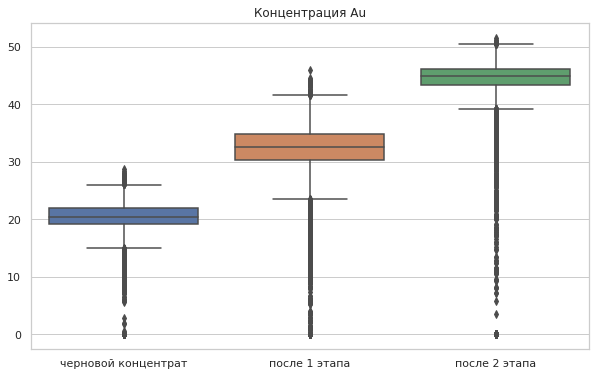

In [8]:
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.boxplot(data=full_data[['rougher.output.concentrate_au', 
                            'primary_cleaner.output.concentrate_au', 
                            'final.output.concentrate_au']]).set_title('Концентрация Au')

plt.xticks([0, 1, 2], ['черновой концентрат', 'после 1 этапа', 'после 2 этапа'])
plt.show()




Концентрация золота с каждым этапом увеличивается. Большинство аномалий меньше Q1.

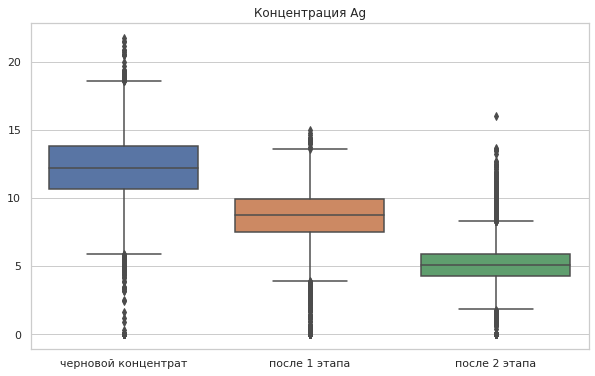

In [9]:
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.boxplot(data=full_data[['rougher.output.concentrate_ag', 
                            'primary_cleaner.output.concentrate_ag', 
                            'final.output.concentrate_ag']]).set_title('Концентрация Ag')

plt.xticks([0, 1, 2], ['черновой концентрат', 'после 1 этапа', 'после 2 этапа'])
plt.show()


Концентрация серебра уменьшается с каждым этапом.Большинство аномалий меньше Q1.

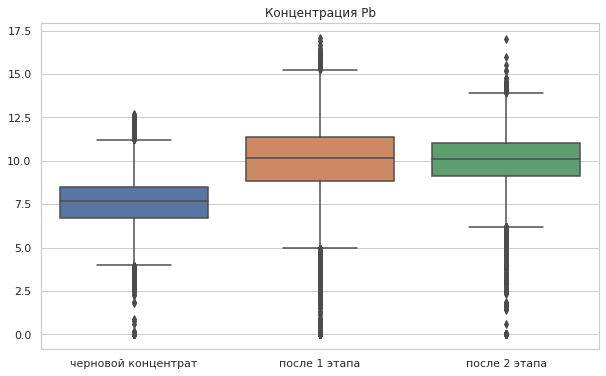

In [10]:
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.boxplot(data=full_data[['rougher.output.concentrate_pb', 
                            'primary_cleaner.output.concentrate_pb', 
                            'final.output.concentrate_pb']]).set_title('Концентрация Pb')

plt.xticks([0, 1, 2], ['черновой концентрат', 'после 1 этапа', 'после 2 этапа'])
plt.show()


Концентрация свинца увеличивается после флотации, далее остается на том же уровне.Большинство аномалий меньше Q1.

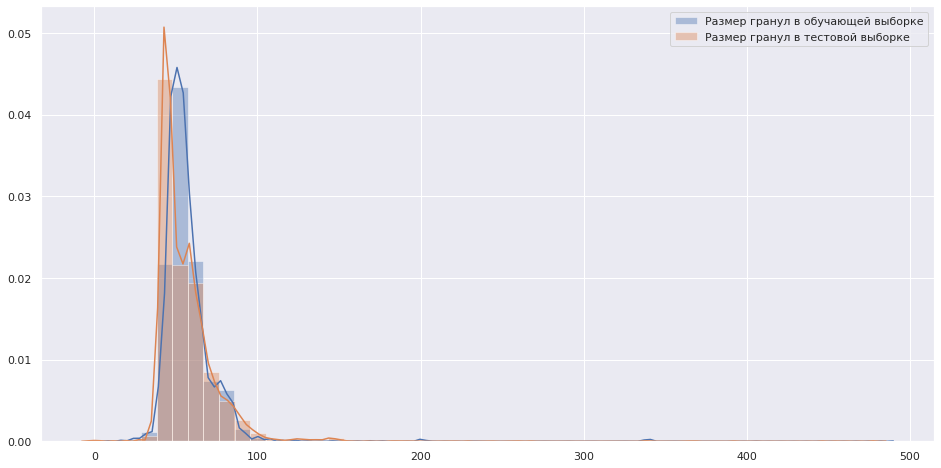

In [11]:
#распределениe размеров гранул сырья на обучающей и тестовой выборках

plt.figure(figsize=(16, 8))
sns.set(style='darkgrid')
sns.distplot(train_data[['rougher.input.feed_size']],  label='Размер гранул в обучающей выборке')
sns.distplot(test_data[['rougher.input.feed_size']], label='Размер гранул в тестовой выборке')
plt.legend()
plt.show()

Распределения на тестовой и обучающей выборках практически совпадают, оценка модели будет корректной.

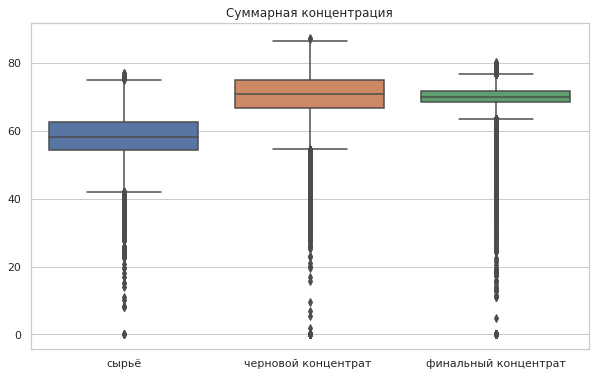

In [12]:
full_data['feed_sum'] = full_data['rougher.input.feed_ag']+full_data['rougher.input.feed_au']+full_data['rougher.input.feed_pb']+full_data['rougher.input.feed_sol']
full_data['primary_sum']= full_data['rougher.output.concentrate_ag']+full_data['rougher.output.concentrate_au']+full_data['rougher.output.concentrate_pb']+full_data['rougher.output.concentrate_sol']
full_data['final_sum'] = full_data['final.output.concentrate_ag']+full_data['final.output.concentrate_au']+full_data['final.output.concentrate_pb']+full_data['final.output.concentrate_sol']


#для оценки изменения суммарной концентрации металлов  на каждом этапе
# feed_sum - сырьё
# primary_sum - черновой концентрат 
# final_sum - финальный концентрат


plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.boxplot(data=full_data[['feed_sum', 
                            'primary_sum', 
                            'final_sum']]).set_title('Суммарная концентрация')

plt.xticks([0, 1, 2], ['сырьё', 'черновой концентрат ', 'финальный концентрат'])
plt.show()




Суммарная концентрация(исходные данные) - растет, но выбросов с каждым этапом становится больше.

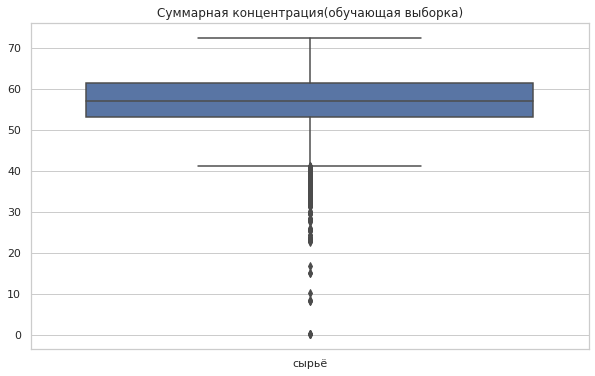

In [13]:
train_data['feed_sum'] = train_data['rougher.input.feed_ag']+train_data['rougher.input.feed_au']+train_data['rougher.input.feed_pb']+train_data['rougher.input.feed_sol']

plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.boxplot(data=train_data[['feed_sum']]).set_title('Суммарная концентрация(обучающая выборка)')

plt.xticks([0], ['сырьё'])
plt.show()

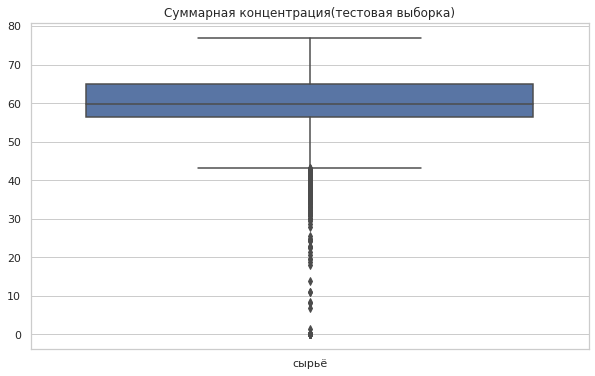

In [14]:
test_data['feed_sum'] = test_data['rougher.input.feed_ag']+test_data['rougher.input.feed_au']+test_data['rougher.input.feed_pb']+test_data['rougher.input.feed_sol']

plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.boxplot(data=test_data[['feed_sum']]).set_title('Суммарная концентрация(тестовая выборка)')

plt.xticks([0], ['сырьё'])
plt.show()

Тк выбросов с каждым этапом очистки становится все больше - они могут повлиять на качество модели. Большинство аномалий сосредоточено ниже Q1(~43) - удалим из выборок строки, где суммарная концентрация <= 43.

In [15]:
train_data = train_data.query('feed_sum > 43')
test_data = test_data.query('feed_sum > 43')


Аномалии удалены из тестовой и обучающей выборок.

# 3. Модель

In [16]:
#sMAPE

def smape(target, predicted):
    return 100/len(target) * np.sum(2 * np.abs(target - predicted) / (np.abs(target) + np.abs(predicted)))

Функция для подсчёта sMAPE готова.

In [17]:
features_train = train_data.drop(['rougher.output.recovery', 'final.output.recovery', 'feed_sum'], axis=1)
target_train_rougher = train_data['rougher.output.recovery']
target_train_final = train_data['final.output.recovery']


Признаки и два целевых признака обучающей выборки готовы.

In [18]:
# подбираем параметры разных моделей
print('дерево решений')
for i in range(1, 11):
    model1 = DecisionTreeRegressor(random_state=12345, max_depth=i)
    rougher_predict_tree= cross_val_predict(model1, features_train, target_train_rougher, cv=5)
    final_predict_tree= cross_val_predict(model1, features_train, target_train_final, cv=5)
    smape_rougher_tree = smape(target_train_rougher,rougher_predict_tree)
    smape_final_tree = smape(target_train_final,final_predict_tree)
    final_smape_tree = 0.25 * smape_rougher_tree + 0.75 * smape_final_tree
    print("max_depth =", i, "итоговое smape:",final_smape_tree)

дерево решений
max_depth = 1 итоговое smape: 9.13582942449145
max_depth = 2 итоговое smape: 10.247629919797383
max_depth = 3 итоговое smape: 10.067125346273547
max_depth = 4 итоговое smape: 10.427513096322315
max_depth = 5 итоговое smape: 11.223396195050306
max_depth = 6 итоговое smape: 16.070731809641288
max_depth = 7 итоговое smape: 17.79071782971318
max_depth = 8 итоговое smape: 18.01318108268881
max_depth = 9 итоговое smape: 18.11935421490437
max_depth = 10 итоговое smape: 19.737249391772018


Лучшее sMAPE для дерева решений 9.13582942449145

In [19]:
print('случайный лес')
for estimators in range(10, 51, 10):
    for depth in range(1,11):
        model2 = RandomForestRegressor(n_estimators=estimators, max_depth=depth, random_state=12345)
        rougher_predict_forest= cross_val_predict(model2, features_train, target_train_rougher, cv=5)
        final_predict_forest= cross_val_predict(model2, features_train, target_train_final, cv=5)
        smape_rougher_forest = smape(target_train_rougher,rougher_predict_forest)
        smape_final_forest = smape(target_train_final,final_predict_forest)
        final_smape_forest = 0.25 * smape_rougher_forest + 0.75 * smape_final_forest
        print("n_estimators =", estimators,"depth =", depth, "итоговое smape:",final_smape_forest)

случайный лес
n_estimators = 10 depth = 1 итоговое smape: 9.129380756607837
n_estimators = 10 depth = 2 итоговое smape: 9.96509374199084
n_estimators = 10 depth = 3 итоговое smape: 9.898751755999758
n_estimators = 10 depth = 4 итоговое smape: 10.243449239976844
n_estimators = 10 depth = 5 итоговое smape: 10.382606586167467
n_estimators = 10 depth = 6 итоговое smape: 10.918916967680442
n_estimators = 10 depth = 7 итоговое smape: 12.029216302215968
n_estimators = 10 depth = 8 итоговое smape: 11.997435455898419
n_estimators = 10 depth = 9 итоговое smape: 12.392298493348008
n_estimators = 10 depth = 10 итоговое smape: 12.50855556966015
n_estimators = 20 depth = 1 итоговое smape: 9.132332225379962
n_estimators = 20 depth = 2 итоговое smape: 9.899159307213083
n_estimators = 20 depth = 3 итоговое smape: 9.765851563783821
n_estimators = 20 depth = 4 итоговое smape: 9.917193729810393
n_estimators = 20 depth = 5 итоговое smape: 10.033262690231414
n_estimators = 20 depth = 6 итоговое smape: 10.23

Лучшее sMAPE для случайного леса 9.129380756607837

In [20]:
print('логистическая регрессия')
model3 = LinearRegression()
rougher_predict_regr= cross_val_predict(model3, features_train, target_train_rougher, cv=5)
final_predict_regr= cross_val_predict(model3, features_train, target_train_final, cv=5)
smape_rougher_regr = smape(target_train_rougher,rougher_predict_regr)
smape_final_regr = smape(target_train_final,final_predict_regr)
final_smape_regr = 0.25 * smape_rougher_regr + 0.75 * smape_final_regr
print("итоговое smape:",final_smape_regr)


логистическая регрессия
итоговое smape: 10.261925732535342


Лучшее sMAPE для логистической регрессии 10.261925732535342

Итоговой моделью будет случайный лес с параметрами: n_estimators = 10 depth = 1

In [21]:
features_test = test_data.drop(['rougher.output.recovery', 'final.output.recovery', 'feed_sum'], axis=1)
target_test_rougher = test_data['rougher.output.recovery']
target_test_final = test_data['final.output.recovery']


model=RandomForestRegressor(n_estimators=10, max_depth=1, random_state=12345)
model.fit(features_train, target_train_rougher)
test_predictions_rougher = model.predict(features_test)
smape_rougher_final = smape(target_test_rougher,test_predictions_rougher)
model.fit(features_train, target_train_final)
test_predictions_final = model.predict(features_test)
smape_final_final = smape(target_test_final,test_predictions_final)
final_smape = 0.25 * smape_rougher_final + 0.75 * smape_final_final
print("итоговое smape:",final_smape)

итоговое smape: 8.796857393500435


Итоговое smape выбранной модели 8.796857393500435. Проверим модель на адекватность(сравним с моделью, где все значение средние).

<font color='green'>Прекрасная работа, молодец. </font>


In [22]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(features_train, target_train_rougher)
dummy_predictions_rougher = dummy_regr.predict(features_test)
smape_rougher_dummy = smape(target_test_rougher,dummy_predictions_rougher)
dummy_regr.fit(features_train, target_train_final)
dummy_predictions_final = dummy_regr.predict(features_test)
smape_final_dummy = smape(target_test_final,dummy_predictions_final)
final_smape_dummy = 0.25 * smape_rougher_dummy + 0.75 * smape_final_dummy
print("итоговое smape:",final_smape_dummy)

итоговое smape: 7.913886651005389


Итоговое smape дамми-модели меньше smape нашей выбранной модели.

## Вывод. Модели машинного обучения для данной задачи некорректны, качество предсказаний ниже, чем при использовании модели, которая всегда возвращает среднее значение.